# Hyperparameter tuning

Run `scripts/hyperparameter_tuning.py` to tune hyperparameters for gene expression prediction correctness and cell mapping consistency, agreement, and certainty on mouse cortex data. The results will be saved in `hyperparameter_tuning.csv`.

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns

sc.logging.print_header()
import squidpy as sq
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/merle/anaconda3/envs/tangramx-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.9.2 umap==0.5.7 numpy==1.24.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 pynndescent==0.5.13
squidpy==1.2.3


In [ ]:
df = pd.read_csv("hyperparameter_tuning.csv",index_col=0)
df

,cell_map_consistency,cell_map_agreement,cell_map_certainty,gene_expr_consistency,gene_expr_correctness,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,...,config/learning_rate,config/lambda_g1,config/lambda_g2,config/lambda_d,config/lambda_r,config/lambda_l2,config/lambda_neighborhood_g1,config/lambda_ct_islands,config/lambda_getis_ord,logdir
0,0.275381,0.899962,0.000000,1.000000,0.473240,1732837181,NaN,False,1,9d382377,...,0.953589,0.574847,0.397710,0.351368,6.006613e-09,3.162183e-04,0.986274,0.456249,0.587608,9d382377
1,0.697110,0.936581,0.884453,0.998080,0.473993,1732837246,NaN,False,1,fa4fae09,...,0.260913,0.457221,0.116556,0.387623,2.299081e-18,5.796728e-20,0.813820,0.486007,0.836863,fa4fae09
2,0.571005,0.916149,0.865171,0.997269,0.473759,1732837309,NaN,False,1,4dd4f8eb,...,0.078299,0.300466,0.664883,0.332220,2.647957e-09,2.873784e-13,0.272255,0.142102,0.863553,4dd4f8eb
3,0.715369,0.937584,0.865904,0.998387,0.474217,1732837374,NaN,False,1,0188bdff,...,0.160602,0.963271,0.708497,0.815533,1.102309e-11,2.921717e-17,0.159393,0.513770,0.531630,0188bdff
4,0.633976,0.919742,0.000000,1.000000,0.473212,1732837439,NaN,False,1,36036de9,...,0.337806,0.330412,0.331825,0.236341,3.177144e-16,7.451702e-06,0.084303,0.555702,0.407500,36036de9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.116590,0.871218,0.000000,1.000000,0.473128,1732982983,NaN,False,1,96610dda,...,0.010070,0.629929,0.958091,0.562092,1.349148e-16,8.762633e-05,0.246061,0.017509,0.831731,96610dda
1996,0.969679,0.974896,0.000000,1.000000,0.473170,1732983063,NaN,False,1,2ab2c5db,...,0.058188,0.729159,0.396876,0.464900,4.810504e-13,5.000289e-05,0.819763,0.855663,0.836779,2ab2c5db
1997,0.036508,0.819076,0.817509,0.990239,0.473932,1732983139,NaN,False,1,e58e9d7b,...,0.090247,0.585028,0.999527,0.837011,4.508843e-06,1.310105e-16,0.127286,0.057110,0.780582,e58e9d7b
1998,0.029344,0.817365,0.816204,0.989543,0.473834,1732983218,NaN,False,1,3985deec,...,0.090251,0.215357,0.096516,0.538448,4.232210e-06,1.203623e-13,0.717406,0.018045,0.299636,3985deec


In [3]:
xlabel = {
    "cell_map_consistency" : "Cell mapping\nconsistency",
    "cell_map_agreement" : "Cell mapping\nagreement",
    "cell_map_certainty" : "Cell mapping\ncertainty",
    "gene_expr_consistency" : "Gene expr prediction\nconsistency",
    "gene_expr_correctness" : "Gene expr prediction\ncorrectness",
    "config/lambda_d" : "$\lambda_\mathrm{cell\ densities}$",
    "config/lambda_g1" : "$\lambda_\mathrm{gene\ expr1}$",
    "config/lambda_g2" : "$\lambda_\mathrm{gene\ expr2}$",
    "config/lambda_r" : "$\lambda_\mathrm{entropy\ reg}$",
    "config/lambda_l1" : "l1 regularization",
    "config/lambda_l2" : "$\lambda_\mathrm{L2\ reg}$",
    "config/lambda_neighborhood_g1" : "$\lambda_\mathrm{spatial\ gene\ expr}$",
    "config/lambda_ct_islands" : "$\lambda_\mathrm{ct\ islands}$",
    "config/lambda_getis_ord" : "$\lambda_{\mathrm{Getis-Ord\ } G*}$",
    "config/learning_rate" : "lr",
}
xlimit = {
    "val_gene_score" : [-0.1,1.1],
    "cell_map_consistency" : [-0.1,1.1],
    "gene_expr_consistency" : [-0.1,1.1],
    "cell_map_agreement" : [-0.1,1.1],
    "cell_map_certainty" : [-0.1,1.1],
    "config/lambda_d" : [-0.1,1.1],
    "config/lambda_g1" : [-0.1,1.1],
    "config/lambda_g2" : [-0.1,1.1],
    "config/lambda_r" : [0.5e-20, 0.0075],
    "config/lambda_l1" : [0.5e-20, 0.0075],
    "config/lambda_l2" : [0.5e-20, 0.0075],
    "config/lambda_neighborhood_g1" :[-0.1,1.1],
    "config/lambda_ct_islands" : [-0.1,1.1], 
    "config/lambda_getis_ord" : [-0.1,1.1],
    "config/learning_rate" : [0.005, 1.5]
}

In [4]:
metric_names1 = ['gene_expr_correctness']
metric_names2 = ['gene_expr_consistency','cell_map_consistency','cell_map_agreement','cell_map_certainty']
custom_cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:orange"])

In [5]:
df1 = df.sort_values("gene_expr_correctness",ascending=False)[:20].copy()
df1["metric"] = xlabel["gene_expr_correctness"]
df6 = df.sort_values("gene_expr_consistency",ascending=False)[:20].copy()
df6["metric"] = xlabel["gene_expr_consistency"]
df7 = df.sort_values("cell_map_consistency",ascending=False)[:20].copy()
df7["metric"] = xlabel["cell_map_consistency"]
df4 = df.sort_values("cell_map_agreement",ascending=False)[:20].copy()
df4["metric"] = xlabel["cell_map_agreement"]
df5 = df.sort_values("cell_map_certainty",ascending=False)[:20].copy()
df5["metric"] = xlabel["cell_map_certainty"]
df_top = pd.concat([df1,df6,df7,df4,df5])

/tmp/ipykernel_47312/1197301320.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,


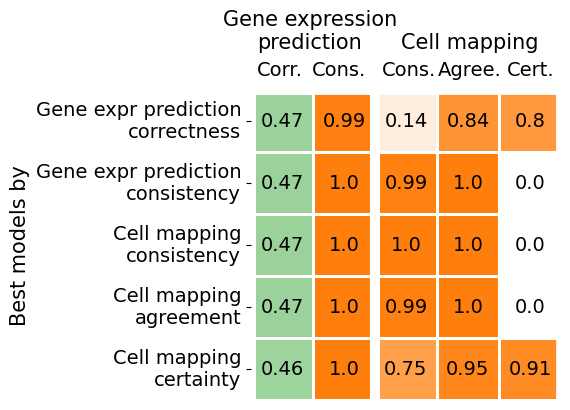

In [ ]:
vals = ["gene_expr_correctness",
        "gene_expr_consistency",
        "cell_map_consistency",
        "cell_map_agreement",
        "cell_map_certainty"]
df_subset2 = pd.DataFrame()
for m in df_top["metric"].unique():
        df_tmp = pd.DataFrame(df_top[df_top["metric"] == m][vals].mean()).T
        df_tmp.index = [m]
        df_subset2 = pd.concat([df_subset2,df_tmp])

fig, ax = plt.subplots(1,1, figsize=(0.6*df_subset2.shape[0]+1, 1*df_subset2.shape[1]), 
                       sharey=True,)
ax.set_aspect("equal")

group_labels = ["Gene expression\nprediction","Cell mapping"]
group_labels2 = ["Correctness","Consistency", "Consistency","Agreement", "Certainty","Consistency", "Agreement", "Certainty"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert."]
group_positions = [[0,1],[2,4]]
ncols = df_subset2.shape[1]
nrows = df_subset2.shape[0] + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3]
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,
                group_labels2[i],
                ha='center',# va="bottom", 
                color="black", size=14,#rotation=90,
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.4, group, ha="center", va="bottom", 
            color="black",
            size=15,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2],
                                            [custom_cmap1,custom_cmap2]):
    data = df_subset2.copy()
    data.loc[:,list(set(df_subset2.columns)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1,#4, 
                annot=df_subset2.round(decimals=2).astype("str"), 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 14,"color":"black"},
                vmin=0,vmax=1,
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.set_ylabel('Best models by', fontsize=15)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))

To ensure optimal performance, we prioritized models that achieved the best balance between cell mapping certainty and consistency, given that gene expression and agreement values remained stable across all top models.

(-0.05, 1.05)

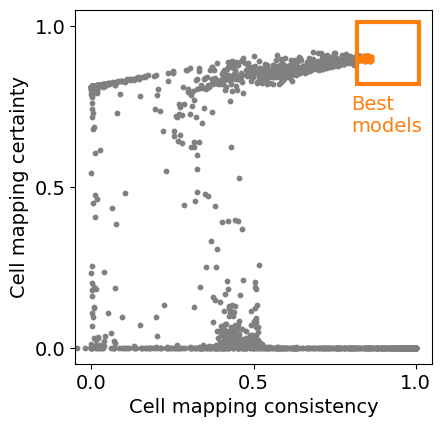

In [ ]:
import matplotlib.patches as patches
 
ax = df.plot(x="cell_map_consistency",y="cell_map_certainty",kind="scatter",s=10,color="grey", figsize=(4.6,4.6))
df[df["cell_map_consistency"] > 0.83][df["cell_map_certainty"] > 0.83].plot(x="cell_map_consistency",
                                                                             y="cell_map_certainty",
                                                                             ax=ax,kind="scatter",
                                                                             color="tab:orange",s=12)
square = patches.Rectangle((0.82, 0.82), 0.190, 0.19, edgecolor='tab:orange', facecolor='none',
                           linewidth=3)
ax.text(s="Best\nmodels",x=0.8, y=0.67,fontsize=14,color="tab:orange")
ax.add_patch(square)
ax.set_xlabel("Cell mapping consistency", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1])
ax.set_ylabel("Cell mapping certainty", fontsize=14)
ax.set_xlim((-0.05,1.05))
ax.set_ylim((-0.05,1.05))

In [ ]:
df[df["cell_map_consistency"] > 0.86][df["cell_map_certainty"] > 0.86]

,cell_map_corr,cell_map_vote_entropy,cell_map_consensus_entropy,gene_corr,val_gene_score,val_sp_sparsity_weighted_score,val_auc_score,val_prob_entropy,timestamp,checkpoint_dir_name,...,config/learning_rate,config/lambda_g1,config/lambda_g2,config/lambda_d,config/lambda_r,config/lambda_l2,config/lambda_neighborhood_g1,config/lambda_ct_islands,config/lambda_getis_ord,logdir
51,0.860976,0.964244,0.902953,0.999042,0.465465,0.702400,0.621351,0.890342,1732840464,NaN,...,0.716201,0.755746,0.993703,0.886122,2.950596e-09,1.001063e-18,0.962755,0.169385,0.711606,38c92bb1
1218,0.861189,0.963425,0.893553,0.999082,0.465886,0.703105,0.621971,0.893216,1732925345,NaN,...,0.683166,0.768835,0.562882,0.914751,2.316575e-18,1.177388e-12,0.999802,0.000105,0.137975,dad3340e


In [36]:
df2 = df[df["cell_map_consistency"] > 0.85][df["cell_map_certainty"] > 0.85]
df2["metric"] = "\n$\\it{Cell\ mapping}$\n$\\it{consistency}$\n$\\it{&\ certainty}$"#"$\bm{Cell mapping}\n\bm{consistency & certainty}$"
df_top = pd.concat([df_top,df2])

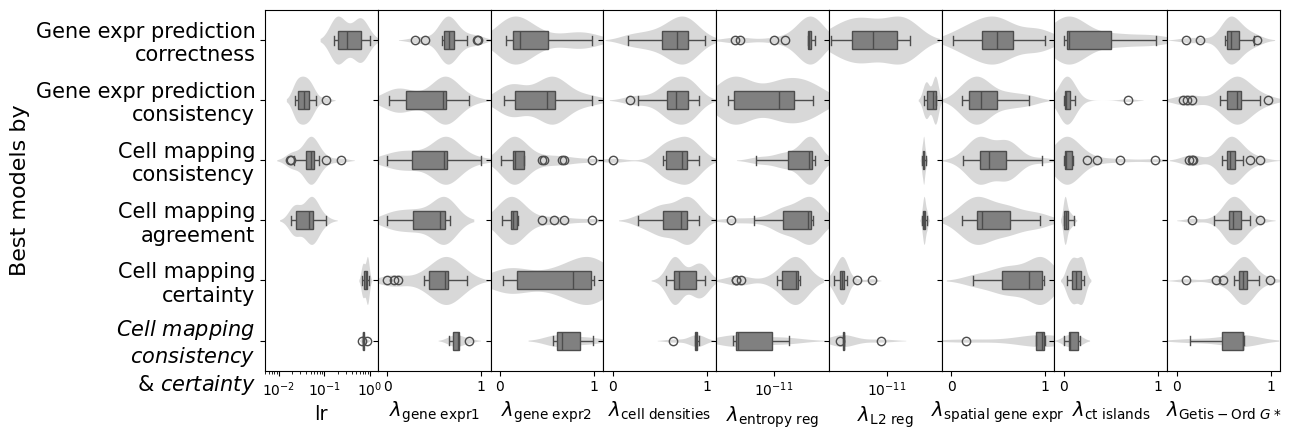

In [37]:
fig, axs = plt.subplots(1, 9, figsize=(13,4.5),sharey=True)
colors = ['green','orange','orange','orange','orange',
          "gray","gray","gray","gray","gray","gray","gray"]
vals = [
        "config/learning_rate",
        "config/lambda_g1",
        "config/lambda_g2",
        "config/lambda_d",
        "config/lambda_r","config/lambda_l2",
        "config/lambda_neighborhood_g1","config/lambda_ct_islands","config/lambda_getis_ord",
        ]
for val,ax,col in zip(vals,axs.flatten(),colors):
    if val in ["config/learning_rate","config/lambda_r","config/lambda_l1","config/lambda_l2"]:
        sns.violinplot(df_top,x=val,y="metric",ax=ax, color="grey",
                       scale="count",
                        saturation=0.7,fill=True,alpha=0.3,linewidth=0,inner=None,
                       log_scale=True,
                       inner_kws=dict(box_width=6, whis_width=2))
        sns.boxplot(df_top,x=val,y="metric",ax=ax, color="grey", width=0.3,
                    boxprops={'zorder': 2})
        ax.set_xscale('log')
        ax.set_xlim(xlimit[val])
    else: 
        sns.violinplot(df_top,x=val,y="metric",
                    ax=ax, color="grey",
                    saturation=0.7,fill=True,alpha=0.3,linewidth=0,inner=None,
                    scale="count",
                    inner_kws=dict(box_width=6, whis_width=2))
        sns.boxplot(df_top,x=val,y="metric",ax=ax, color="grey", width=0.3,
                    boxprops={'zorder': 2})
    ax.set_ylabel("Best models by", fontsize=16)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel(xlabel[val], fontsize=14)
    ax.set_xlim(xlimit[val])
    
    if val in ["cell_map_agreement","cell_map_certainty"]:
        ax.xaxis.set_inverted(True)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.show()

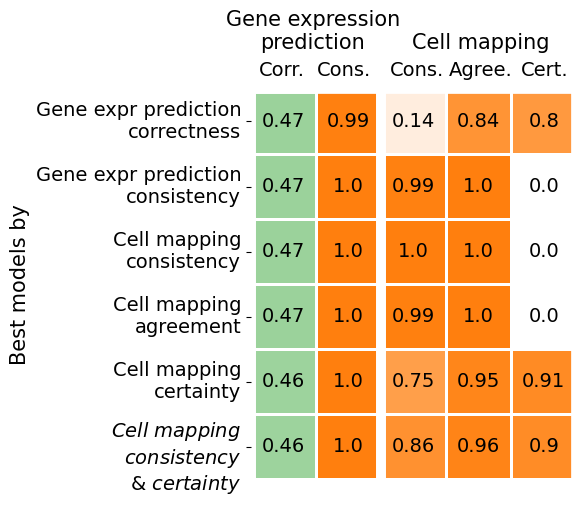

In [ ]:
vals = ["gene_expr_correctness",
        "gene_expr_consistency",
        "cell_map_consistency",
        "cell_map_agreement",
        "cell_map_certainty"]
df_subset2 = pd.DataFrame()
for m in df_top["metric"].unique():
        df_tmp = pd.DataFrame(df_top[df_top["metric"] == m][vals].mean()).T
        df_tmp.index = [m]
        df_subset2 = pd.concat([df_subset2,df_tmp])
        
fig, ax = plt.subplots(1,1, figsize=(0.6*df_subset2.shape[0]+0.6, 1*df_subset2.shape[1]+1), 
                       sharey=True,)
ax.set_aspect("equal")
from matplotlib.patches import Rectangle
group_labels = ["Gene expression\nprediction","Cell mapping"]
group_labels2 = ["Correctness","Consistency", "Consistency","Agreement", "Certainty","Consistency", "Agreement", "Certainty"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert."]
group_positions = [[0,1],[2,4]]
ncols = df_subset2.shape[1]
nrows = df_subset2.shape[0] + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3]
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,
                group_labels2[i],
                ha='center',# va="bottom", 
                color="black", size=14,#rotation=90,
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.4, group, ha="center", va="bottom", 
            color="black",
            size=15,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2],
                                            [custom_cmap1,custom_cmap2]):
    data = df_subset2.copy()
    data.loc[:,list(set(df_subset2.columns)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1,#4, 
                annot=df_subset2.round(decimals=2).astype("str"), 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 14,"color":"black"},
                vmin=0,vmax=1,
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.set_ylabel('Best models by', fontsize=15)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))